In this notebook we implement a basic echo state network.

In [1]:
from jax import numpy as jnp, random
from jax.lax import scan
import jax
from jax.scipy.special import erf
from jax.scipy.linalg import cho_solve, cho_factor

from reservoirtaming.data.KS import KS

from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
sns.set()

In [2]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 2000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

np.random.seed(1)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()

In [3]:
# Prepping train and test matrices
# why the sqrt scaling?
_, u_train, u_test, _ = np.split(dns.uu / jnp.sqrt(N), 
                                     [N_init, 
                                     (N_init + N_train), 
                                     (N_init + N_train + N_test)], axis=0)

n_input = u_train.shape[1]

In [4]:
# Hyperparams
n_reservoir = 3996
input_scale = 0.4
res_scale = 0.9
leak_rate = 1.0
bias_scale = 0.1

renorm_factor = 1.1 * jnp.sqrt(n_input / n_reservoir)
alpha = 1e-2

In [5]:
# Making arrays for gaussian dense echo state network
key = random.PRNGKey(42)
key_in, key_res, key_bias = random.split(key, 3)

# We can just multiply the weights with the scale for speed
W_in = input_scale * random.normal(key_in, shape=(n_reservoir, n_input)) # weights for inputs
W_res = res_scale * random.normal(key_res, shape=(n_reservoir, n_reservoir)) # weights for previous state
bias = bias_scale * random.normal(key_bias, shape=(n_reservoir, ))
reservoir_init = jnp.zeros((n_reservoir, )) # initial input state for reservoir since it hasn't run yet

In [6]:
%%time
# Leaky update function with all the possible parameters
def echo_state_update_leaky(f, W_in, W_res, bias, leak_rate, renorm_factor, reservoir_state, inputs):
    z = jnp.dot(W_in, inputs) + jnp.dot(W_res, reservoir_state) + bias
    new_state = (1.0 - leak_rate) * reservoir_state + leak_rate * f(z) / jnp.sqrt(n_reservoir)
    save_state = jnp.concatenate([new_state, renorm_factor * inputs])
    return new_state, save_state # we return two outputs: first the state of network to use for next iteration, second state + inputs for fitting


# Except for the last two inputs, all these stay fixed, so let's make life easier by making a partial function:
# This function can be scanned over simply to implement a reservoir network super efficiently:
# Basically, it outputs a function with the following signature:
# (new_state, fit_state) = update_state(current_state, input)
# We can them easily run the reservoir using jax.lax.scan; https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html
# What is does is run the updated_state function for the first time using reservoir_init and the first row in u_train
# Than it takes the first output (see above) and uses that as the reservoir input for the next iteration
# and saves the second input (which is also the reservoir state + the input, useful for training etc)

update_state = partial(echo_state_update_leaky, erf, W_in, W_res, bias, leak_rate, renorm_factor)
final_reservoir_state, output = scan(update_state, reservoir_init, u_train) # final reservoir state has shape n_reservoir, output (N_train, (n_reservoir + n_input))

CPU times: user 1.8 s, sys: 66.4 ms, total: 1.86 s
Wall time: 1.92 s


In [7]:
output.shape

(10000, 4096)

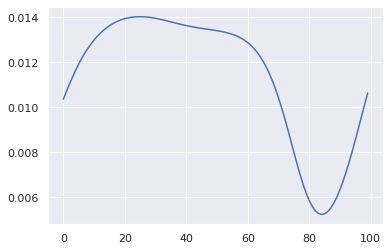

In [11]:
plt.plot(output[5000:5100, 400])

In [7]:
%%time
# Now we calculate the output layer using l2
# We add the prediction u and use move u up 1 frame for y
# i.e. the the first input of the reservoir is zeros for the previous state, and 
# first frame of the training data and predicts the second frame

X = output[:-1]
y = u_train[1:]

# we use cholesky decomp to solve the problem; fast, efficient and stable
# This seems much slower than what jonathan reports in the paper; we'll have to compare implementations
# It is *much* faster the second time we run it though; maybe an issue with jit?
c, low = cho_factor(jnp.dot(X.T, X) + alpha * jnp.eye(X.shape[1]))
W_out = cho_solve((c, low), jnp.dot(X.T, y))

CPU times: user 1.31 s, sys: 325 ms, total: 1.64 s
Wall time: 2.24 s


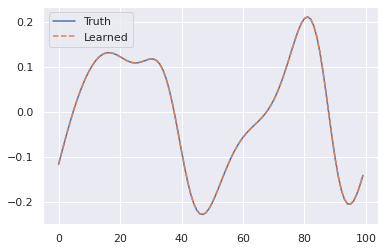

In [8]:
# Did we do everything correctly - just a sanity check
u_pred = jnp.dot(X, W_out)
frame = 500
plt.plot(u_train[frame + 1], label='Truth')
plt.plot(u_pred[frame], '--', label='Learned')

plt.legend()

In [9]:
%%time
# This function can be used as an update function with scan to recursively predict
# We just wrap the forward pass function
def predict(carry, pred_frame):
    reservoir_state, previous_prediction = carry
    updated_state, output = update_state(reservoir_state, previous_prediction)
    prediction = jnp.dot(output, W_out)
    return (updated_state, prediction), prediction

n_steps_predict = 2000
prediction_reservoir_state, prediction = scan(predict, (final_reservoir_state, u_train[-1]), jnp.arange(n_steps_predict))

CPU times: user 518 ms, sys: 128 ms, total: 646 ms
Wall time: 695 ms


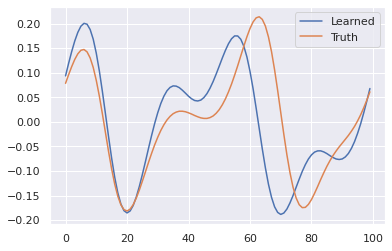

In [10]:
frame = 100
plt.plot(prediction[frame], label='Learned')
plt.plot(u_test[frame], label='Truth')

plt.legend()

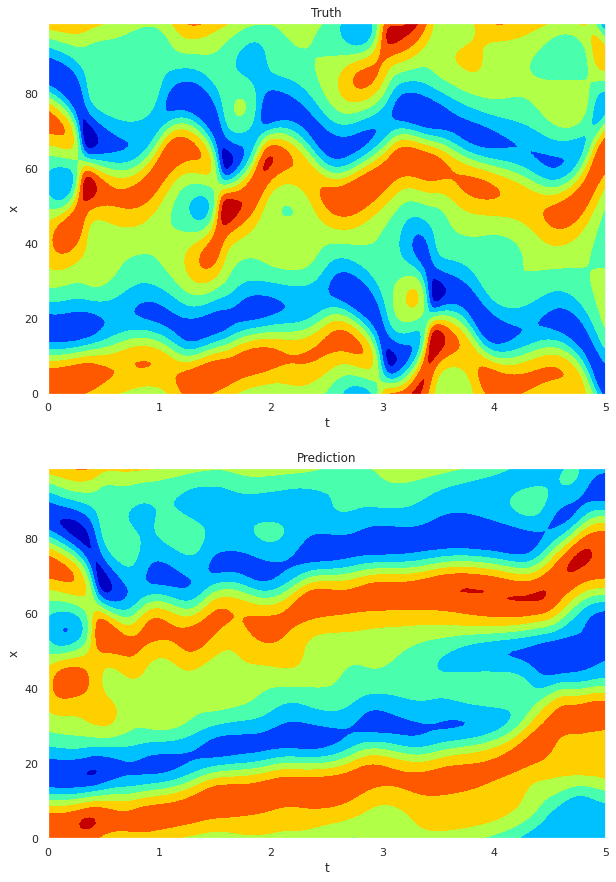

In [11]:
N_lyap = 5
lyap_exp = 0.043
lyap_time = 1 / lyap_exp
lyap_idx = int(lyap_time / dt)

plt.figure(figsize=(10, 15))
plt.subplot(211)
plt.title('Truth')
plt.contourf(u_test[:(N_lyap * lyap_idx)].T, cmap='jet')
plt.ylabel('x')
plt.xlabel('t')
plt.xticks(np.arange(N_lyap + 1) * lyap_idx, np.arange(N_lyap + 1))

plt.subplot(212)
plt.title('Prediction')
plt.contourf(prediction[:(N_lyap * lyap_idx)].T, cmap='jet')
plt.ylabel('x')
plt.xlabel('t')
plt.xticks(np.arange(N_lyap + 1) * lyap_idx, np.arange(N_lyap + 1))

plt.show()